# 🚀 CEO Advantage: 24/7 Smart Research & Reporting System

> **This system gives the CEO the power of a full-time research and analysis team, working 24/7, delivering clear, smart, and up-to-date reports — fast, cheap, and reliably.**

---

## ✅ Key Benefits for the CEO

- ⏱️ **Saves Time** – Full reports in minutes instead of hours/days  
- 📚 **In-Depth + Summary Reports** – Technical detail + executive overview  
- 📊 **Data-Driven Decisions** – Combines academic + market insights  
- 🔄 **Real-Time Updates** – Always uses the latest data (news + research)  
- 👥 **Virtual Team** – Acts like a full research and writing team without hiring  
- 📋 **Consistent Format** – Standardized and structured reporting every time  
- 💰 **Cost-Efficient** – Uses free/public data sources, minimal LLM usage  
- 📈 **Scalable** – Can generate multiple reports at once  
- ⚡ **Faster Reactions** – Respond quickly to new trends or threats  
- 🔍 **Full Transparency** – CEO gets both final outputs and raw sources  
- 🧩 **Flexible Use Cases** – Market research, product strategy, competitor analysis, etc


In [20]:
# ===================================
# CELL 1: Imports and Setup
# ===================================

import os
from typing import TypedDict, Annotated, Dict, List, Literal
from dotenv import load_dotenv

# LangChain imports
from langchain.tools import ArxivQueryRun
from langchain.utilities import ArxivAPIWrapper
from langchain.tools import WikipediaQueryRun
from langchain.utilities import WikipediaAPIWrapper
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_groq import ChatGroq
from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate

# LangGraph imports
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages

# ===================================
# CELL 2: State Definition
# ===================================

class AgentState(TypedDict, total=False):
    query: str
    next_agent: str
    task_complete: bool
    messages: Annotated[List[AIMessage], add_messages]
    research_data: dict
    combined_research: str
    technical_section: str
    summary_section: str
    final_report: str

# ===================================
# CELL 3: Environment Setup
# ===================================

# Load environment variables
load_dotenv()

# Setup API keys with error checking
groq_key = os.getenv("GROQ_API_KEY")
tavily_key = os.getenv("TAVILY_API_KEY")

if groq_key is None:
    print("⚠️  Warning: GROQ_API_KEY not found in environment variables")
else:
    os.environ["GROQ_API_KEY"] = groq_key

if tavily_key is None:
    print("⚠️  Warning: TAVILY_API_KEY not found in environment variables")
else:
    os.environ["TAVILY_API_KEY"] = tavily_key

# Initialize LLM
llm = ChatGroq(
    temperature=0,
    model_name="llama3-70b-8192"
)

# ===================================
# CELL 4: Tool Initialization
# ===================================

# ArXiv Tool Setup
api_wrapper = ArxivAPIWrapper()
arxiv_tool = ArxivQueryRun(
    api_wrapper=api_wrapper,
    top_k=2,
    description="Search for academic papers on arxiv.org"
)

# Wikipedia Tool Setup
wiki_wrapper = WikipediaAPIWrapper()
wiki_tool = WikipediaQueryRun(
    api_wrapper=wiki_wrapper,
    top_k=2,
    description="Search for articles on Wikipedia"
)

# Tavily Search Tool Setup - Fixed initialization
tavily_tool = TavilySearchResults(max_results=3)

print("🔧 Tools initialized:")
print(f"  📄 ArXiv Tool: {arxiv_tool.name}")
print(f"  📖 Wikipedia Tool: {wiki_tool.name}")
print(f"  🔍 Tavily Search: Available")

# ===================================
# CELL 5: Query Analysis Function
# ===================================

def analyze_query_for_research(query: str) -> Dict:
    """Analyze query to decide which researchers to call"""
    query_lower = query.lower()
    
    # Data Researcher keywords
    data_keywords = [
        "algorithm", "research", "technical", "academic", "scientific", 
        "paper", "study", "analysis", "data", "machine learning", "ai",
        "neural network", "deep learning", "statistics", "mathematics",
        "quantum", "physics", "chemistry", "biology", "arxiv", "benchmark"
    ]
    
    # Market Researcher keywords  
    market_keywords = [
        "market", "business", "company", "stock", "financial", 
        "news", "industry", "trend", "economic", "investment",
        "revenue", "profit", "earnings", "valuation", "ipo",
        "price", "trading", "sector", "competition", "chip"
    ]
    
    # Check for keyword matches
    has_data_keywords = any(keyword in query_lower for keyword in data_keywords)
    has_market_keywords = any(keyword in query_lower for keyword in market_keywords)
    
    # Decision logic
    if has_data_keywords and has_market_keywords:
        return {
            "call_data_researcher": True,
            "call_market_researcher": True,
            "reasoning": "Query contains both technical and market elements"
        }
    elif has_data_keywords:
        return {
            "call_data_researcher": True,
            "call_market_researcher": False,
            "reasoning": "Query is primarily technical/academic"
        }
    elif has_market_keywords:
        return {
            "call_data_researcher": False,
            "call_market_researcher": True,
            "reasoning": "Query is primarily market/business focused"
        }
    else:
        return {
            "call_data_researcher": True,
            "call_market_researcher": True,
            "reasoning": "Broad query - calling both researchers for comprehensive coverage"
        }

# ===================================
# CELL 6: Data Researcher Agent
# ===================================

def data_researcher_agent(query: str) -> Dict:
    """Data Researcher using LangChain tools"""
    print(f"🔬 Data Researcher: Researching '{query}'...")
    
    results = {
        "source": "data_researcher",
        "query": query,
        "findings": [],
        "sources": [],
        "technical_insights": [],
        "quality_score": 0,
        "tools_used": []
    }
    
    # ArXiv Search
    try:
        print("  📄 Searching ArXiv...")
        arxiv_results = arxiv_tool.invoke(query)
        
        if arxiv_results and len(arxiv_results.strip()) > 10:
            results["findings"].append({
                "source": "ArXiv",
                "data": arxiv_results,
                "type": "academic_papers"
            })
            results["sources"].append("ArXiv Academic Papers")
            results["tools_used"].append("ArxivQueryRun")
            results["quality_score"] += 40
            print("  ✅ ArXiv search completed")
        else:
            print("  ⚠️  ArXiv search returned no results")
            
    except Exception as e:
        print(f"  ❌ ArXiv search failed: {e}")
    
    # Wikipedia Search
    try:
        print("  📖 Searching Wikipedia...")
        wiki_results = wiki_tool.invoke(query)
        
        if wiki_results and len(wiki_results.strip()) > 10:
            results["findings"].append({
                "source": "Wikipedia",
                "data": wiki_results,
                "type": "encyclopedia_summary"
            })
            results["sources"].append("Wikipedia Technical Summary")
            results["tools_used"].append("WikipediaQueryRun")
            results["quality_score"] += 30
            print("  ✅ Wikipedia search completed")
        else:
            print("  ⚠️  Wikipedia search returned no results")
            
    except Exception as e:
        print(f"  ❌ Wikipedia search failed: {e}")
    
    # Generate Technical Insights
    results["technical_insights"] = [
        f"Academic relevance: {'High' if 'ArXiv' in results['sources'] else 'Medium'}",
        f"Data completeness: {len(results['findings'])}/2 sources retrieved",
        f"Technical depth: {'Comprehensive' if results['quality_score'] > 50 else 'Basic'}",
        f"Tools used: {', '.join(results['tools_used'])}"
    ]
    
    print(f"  📊 Data Research completed with quality score: {results['quality_score']}/100")
    return results

# ===================================
# CELL 7: Market Researcher Agent
# ===================================

def market_researcher_agent(query: str) -> Dict:
    """Market Researcher using LangChain tools"""
    print(f"💹 Market Researcher: Researching '{query}'...")
    
    results = {
        "source": "market_researcher", 
        "query": query,
        "findings": [],
        "sources": [],
        "market_insights": [],
        "sentiment": "neutral",
        "quality_score": 0,
        "tools_used": []
    }
    
    # Tavily Search for latest market/business news
    try:
        print("  🔍 Searching Tavily for latest news...")
        tavily_results = tavily_tool.invoke({"query": query})
        
        if tavily_results and len(str(tavily_results).strip()) > 10:
            results["findings"].append({
                "source": "Tavily",
                "data": tavily_results,
                "type": "current_news_and_trends"
            })
            results["sources"].append("Tavily Current News")
            results["tools_used"].append("TavilySearchResults")
            results["quality_score"] += 45
            print("  ✅ Tavily search completed")
        else:
            print("  ⚠️  Tavily search returned no results")
            
    except Exception as e:
        print(f"  ❌ Tavily search failed: {e}")
    
    # Wikipedia Search for business context
    try:
        print("  📖 Searching Wikipedia for business context...")
        wiki_results = wiki_tool.invoke(query)
        
        if wiki_results and len(wiki_results.strip()) > 10:
            results["findings"].append({
                "source": "Wikipedia",
                "data": wiki_results,
                "type": "business_summary"
            })
            results["sources"].append("Wikipedia Business Summary")
            results["tools_used"].append("WikipediaQueryRun")
            results["quality_score"] += 25
            print("  ✅ Wikipedia search completed")
        else:
            print("  ⚠️  Wikipedia search returned no results")
            
    except Exception as e:
        print(f"  ❌ Wikipedia search failed: {e}")
    
    # Generate Market Insights
    results["market_insights"] = [
        f"Market relevance: {'High' if 'Tavily' in results['sources'] else 'Medium'}",
        f"Information freshness: {'Current' if results['quality_score'] > 40 else 'Historical'}",
        f"Business context: {'Comprehensive' if results['quality_score'] > 50 else 'Basic'}",
        f"Tools used: {', '.join(results['tools_used'])}"
    ]
    
    print(f"  📊 Market Research completed with quality score: {results['quality_score']}/100")
    return results

# ===================================
# CELL 8: Research Results Compiler
# ===================================

def compile_research_results(research_results: Dict, decision: Dict) -> str:
    """Compile research results into a structured summary"""
    quality_metrics = []
    error_count = 0

    # Extract query safely from the first result
    query = next(iter(research_results.values()), {}).get("query", "Unknown")

    # Process each researcher's results
    for research_type, data in research_results.items():
        quality = data.get("quality_score", 0)
        errors = len(data.get("errors", [])) + len(data.get("warnings", []))
        error_count += errors

        quality_metrics.append((
            research_type.replace("_", " ").title(),
            quality,
            errors,
            data.get("findings", [])
        ))

    # Build quality bar visuals
    quality_bars = []
    for name, score, errors, _ in quality_metrics:
        bar = "█" * int(score / 10) + "░" * (10 - int(score / 10))
        quality_bars.append(f"{name:<20} {bar} {score:.0f}/100 | Errors: {errors}")

    # Collect top 5 findings across researchers
    findings_summary = []
    for _, _, _, findings in quality_metrics:
        for finding in findings:
            source = finding.get("source", "Unknown")
            summary = finding.get("type", "data")[:50]
            findings_summary.append(f"• {source}: {summary}...")

    quality_section = "\n".join(quality_bars)
    findings_section = "\n".join(findings_summary[:5])
    if len(findings_summary) > 5:
        findings_section += "\n..."

    return f"""
📊 RESEARCH REPORT
{"=" * 40}
🔍 Query: {query}

📈 Quality Metrics:
{quality_section}

📝 Key Findings:
{findings_section}

⚠️  Total Issues: {error_count}
✅ Decision Rationale: {decision.get("reasoning", '')}
"""

# ===================================
# CELL 9: Agent Functions
# ===================================

def ceo_agent(state: AgentState) -> AgentState:
    """CEO decision agent - Fixed query extraction"""
    print("👔 CEO: Deciding next action...")
    
    # FIXED: Proper query extraction
    query = state.get("query", "")
    if not query:
        messages = state.get("messages", [])
        if messages:
            # Get the first human message
            for msg in messages:
                if isinstance(msg, HumanMessage):
                    query = msg.content
                    break
                elif hasattr(msg, 'content'):
                    query = msg.content
                    break
    
    # Update state with query
    state["query"] = query
    
    # Check if we have research data but no final report
    if state.get("research_data") and not state.get("final_report"):
        print("👔 CEO: Research complete, delegating to writing team...")
        return {
            **state,
            "next_agent": "writing_team"
        }
    
    # Check if we need research
    if not state.get("research_data"):
        print("👔 CEO: No research data, delegating to research team...")
        return {
            **state,
            "next_agent": "research_team"
        }
    
    # If we have final report, we're done
    if state.get("final_report"):
        print("👔 CEO: Task complete!")
        return {
            **state,
            "task_complete": True
        }
    
    # Default fallback
    return {
        **state,
        "next_agent": "research_team"
    }

def research_team_leader_agent(state: AgentState) -> AgentState:
    """Research Team Leader - Fixed query handling"""
    # FIXED: Better query extraction
    query = state.get("query", "")
    if not query:
        messages = state.get("messages", [])
        if messages:
            for msg in messages:
                if isinstance(msg, HumanMessage):
                    query = msg.content
                    break
                elif hasattr(msg, 'content'):
                    query = msg.content
                    break
        if not query:
            query = "General research request"

    print(f"📊 Research Team Leader: Analyzing query: '{query}'")

    # Analyze to decide what kind of research to perform
    decision = analyze_query_for_research(query)

    # Collect research from sub-agents
    research_results = {}
    if decision.get("call_data_researcher"):
        research_results["data_research"] = data_researcher_agent(query)
    if decision.get("call_market_researcher"):
        research_results["market_research"] = market_researcher_agent(query)

    # Combine the research findings
    combined_research = compile_research_results(research_results, decision)

    # Update state
    messages = state.get("messages", [])
    return {
        **state,
        "query": query,
        "research_data": research_results,
        "combined_research": combined_research,
        "research_decision": decision,
        "messages": messages + [AIMessage(content="✅ Research completed.")],
        "next_agent": "ceo_agent"
    }

def technical_writer_agent(state: AgentState) -> AgentState:
    """Technical Writer Agent"""
    print("📝 Technical Writer: Writing technical section...")

    research_data = state.get("research_data", {})
    technical_parts = []

    if "data_research" in research_data:
        findings = research_data["data_research"].get("findings", [])
        for item in findings:
            if item.get("source") == "ArXiv":
                technical_parts.append(f"📄 Based on academic research: {item['data'][:500]}...")
            elif item.get("source") == "Wikipedia":
                technical_parts.append(f"📖 Technical overview: {item['data'][:500]}...")

    technical_section = "\n\n".join(technical_parts) if technical_parts else "No technical details found."

    state["technical_section"] = technical_section
    state["messages"] = state.get("messages", []) + [AIMessage(content="📝 Technical section completed.")]
    return state

def summary_writer_agent(state: AgentState) -> AgentState:
    """Summary Writer Agent - Fixed LLM usage"""
    print("📝 Summary Writer: Writing summary section...")

    combined_research = state.get("combined_research", "")
    
    if not combined_research.strip():
        state["summary_section"] = "⚠️ No research data available to summarize."
        return state

    prompt = ChatPromptTemplate.from_template(
        "Summarize the following research findings into a short, clear executive summary:\n\n{research_text}"
    )

    chain = prompt | llm

    try:
        response = chain.invoke({"research_text": combined_research})
        summary_text = f"📚 Executive Summary:\n\n{response.content}"
    except Exception as e:
        summary_text = f"⚠️ Summary generation failed: {e}"

    state["summary_section"] = summary_text
    state["messages"] = state.get("messages", []) + [AIMessage(content="📝 Summary section completed.")]
    return state

def writing_team_leader_agent(state: AgentState) -> AgentState:
    """Writing Team Leader Agent"""
    print("📋 Writing Team Leader: Delegating writing tasks...")

    # Step 1: Call technical writer
    state = technical_writer_agent(state)

    # Step 2: Call summary writer
    state = summary_writer_agent(state)

    # Step 3: Compose Final Report
    final_report = f"""
🧠 FINAL REPORT
====================
📘 Technical Section:
{state.get('technical_section', 'Not generated')}

📗 Summary Section:
{state.get('summary_section', 'Not generated')}

📊 Research Data Summary:
{state.get('combined_research', 'Not available')}
"""

    # Set both final_report AND task_complete
    return {
        **state,
        "final_report": final_report,
        "task_complete": True,
        "next_agent": "ceo_agent",
        "messages": state.get("messages", []) + [AIMessage(content="✅ Writing completed.")]
    }

# ===================================
# CELL 10: Router Function
# ===================================

def router(state: AgentState) -> Literal["ceo_agent", "research_team", "writing_team", "__end__"]:
    """Router function to determine next agent"""
    next_agent = state.get("next_agent", "ceo_agent")
    task_complete = state.get("task_complete", False)

    print(f"🔄 Router: next_agent={next_agent}, task_complete={task_complete}")

    if task_complete:
        return "__end__"

    if next_agent == "research_team":
        return "research_team"
    elif next_agent == "writing_team":
        return "writing_team"
    else:
        return "ceo_agent"

# ===================================
# CELL 11: Graph Creation
# ===================================

# Create LangGraph
graph = StateGraph(AgentState)

# Add All Nodes
graph.add_node("ceo_agent", ceo_agent)
graph.add_node("research_team", research_team_leader_agent)
graph.add_node("writing_team", writing_team_leader_agent)

# Add Routing
graph.add_conditional_edges("ceo_agent", router)
graph.add_conditional_edges("research_team", router)
graph.add_conditional_edges("writing_team", router)

# Set Start Point
graph.set_entry_point("ceo_agent")

# Compile
app = graph.compile()

# ===================================
# CELL 12: Main Execution
# ===================================

def run_multi_agent_research(query: str):
    """Main function to run the multi-agent research system"""
    print(f"🚀 Starting Multi-Agent Research System for: '{query}'")
    print("=" * 60)
    
    # Create proper initial state
    graph_input = {
        "query": query,
        "messages": [HumanMessage(content=query)],
        "research_data": {},
        "combined_research": "",
        "final_report": "",
        "task_complete": False,
        "next_agent": "ceo_agent"
    }
    
    try:
        # Run the graph
        final_state = app.invoke(graph_input)
        
        # Output results
        print("\n" + "=" * 60)
        print("🧾 FINAL OUTPUT:")
        print("=" * 60)
        print(final_state.get("final_report", "❌ No report generated."))
        
        return final_state
        
    except Exception as e:
        print(f"❌ Error running multi-agent system: {e}")
        return None

# ===================================
# CELL 13: Example Usage
# ===================================

if __name__ == "__main__":
    # Test the system with a proper query
    test_query = "Generate a report on AI chip market trends and technical benchmarks"
    
    result = run_multi_agent_research(test_query)
    
    if result:
        print("\n✅ System completed successfully!")
    else:
        print("\n❌ System failed to complete.")

C:\Users\User\AppData\Local\Temp\ipykernel_14080\3247840840.py:86: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_tool = TavilySearchResults(max_results=3)


🔧 Tools initialized:
  📄 ArXiv Tool: arxiv
  📖 Wikipedia Tool: wikipedia
  🔍 Tavily Search: Available
🚀 Starting Multi-Agent Research System for: 'Generate a report on AI chip market trends and technical benchmarks'
👔 CEO: Deciding next action...
👔 CEO: No research data, delegating to research team...
🔄 Router: next_agent=research_team, task_complete=False
📊 Research Team Leader: Analyzing query: 'Generate a report on AI chip market trends and technical benchmarks'
🔬 Data Researcher: Researching 'Generate a report on AI chip market trends and technical benchmarks'...
  📄 Searching ArXiv...
  ✅ ArXiv search completed
  📖 Searching Wikipedia...
  ✅ Wikipedia search completed
  📊 Data Research completed with quality score: 70/100
💹 Market Researcher: Researching 'Generate a report on AI chip market trends and technical benchmarks'...
  🔍 Searching Tavily for latest news...
  ✅ Tavily search completed
  📖 Searching Wikipedia for business context...
  ✅ Wikipedia search completed
  📊 Market

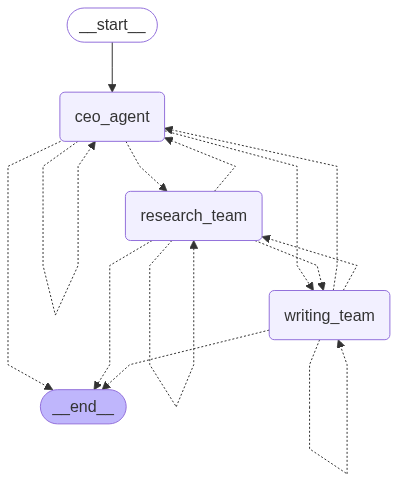

In [21]:
app